# Day 9 - Image Classification with CNNs

### Part 1: Cifar 10
**Loading and Preprocessing the Data**

pyTorch comes with several popular datasets "built in", so you can easily download these without having to deal with custom file formats.

In [93]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.optim as optim

# Load training set
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform = transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load test set
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform = transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Class 2 -- bird


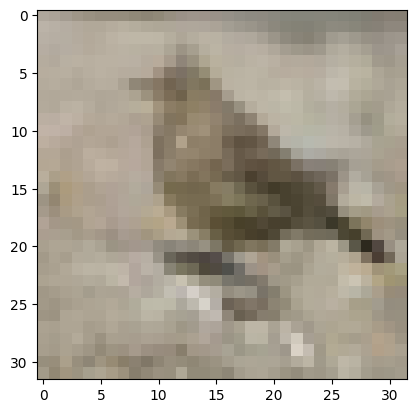

In [92]:
from matplotlib import pyplot as plt

def show_image_and_label(dataset,idx):
    image, label = train_dataset[idx] # Get image and label 
    print(f"Class {label} -- {train_dataset.classes[label]}")  # find corresponding text 
    plt.imshow(image.permute(1,2,0))

show_image_and_label(train_dataset,120)

In [73]:
image,label = train_dataset[0]
image.shape


torch.Size([3, 32, 32])

Note: Each image tensor is of size (3,32,32), which is what the CNN layers expect. To display the image we had to rotate the dimensions so that the tensor matches the format required by matplotlib. 

As we saw with other datasets, normalizing the data is helpful. For each pixel (in each color channel) we want to subract the mean and divide by the standard deviation. Let's compute these first.

In [65]:
def compute_mean_std(dataset):
    
    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_pixels = 0

    for image, label in dataset:
        # image shape: (3, H, W)
        num_pixels += image.shape[1] * image.shape[2] 
        for i in range(3):
            mean[i] += image[i, :, :].sum()
            std[i] += (image[i, :, :] ** 2).sum()

    mean /= num_pixels
    std = (std / num_pixels - mean ** 2).sqrt()
    return mean, std

In [66]:
compute_mean_std(train_dataset)

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

We can then use these values to transform the training data when we read it in.

In [76]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform = transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load test set
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform = transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Class 0 -- airplane
torch.Size([3, 32, 32])


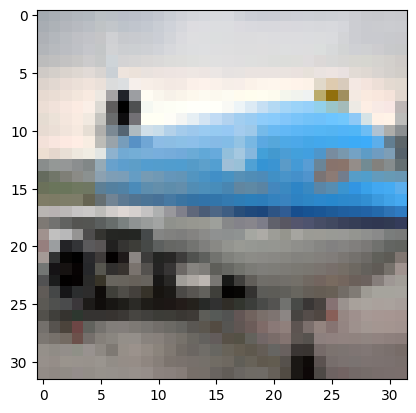

In [80]:
show_image_and_label(train_dataset,700)

*****Building a Convolutional Neural Network*****

Build a CNN vision classifier using alternating layers of 2D convolution and pooling. Finally, pass the representation through two linear layers in order to make a prediction. 
Start with the following architecture, and then continue to experiment. 

* Two convolution "block" of the following:
  1. 2D convolution (Conv2d) with 16 kernels, kernel size 3, stride 1, 1 pixel padding on each side.
  2. pointwise relU activation 
  3. Max pool using a 2,2 window (i.e. cutting the size in half).
* Then feed the resulting representation through a classification layer, and then to the 10 unit output. 
For the hidden layer, start with 64 hidden units. 

For the convolution layers, you will hve to use something like this: 

[`nn.Conv2d(in_channels, out_channels, kernel_size=..., padding=..., stride=...)`](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html)

Note, the out_channels specify the number of kernels. 

For the pooling layers, you will have to use 

[`nn.MaxPool2d(2, 2)`](https://docs.pytorch.org/docs/2.8/generated/torch.nn.MaxPool2d.html) where the parameters specify the size of the sliding window. 

In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):

    def __init__(self): 
        super().__init__()
        #...
        
    def forward(self, x):
        #...
        return 


In [156]:
# Here is some code to train the model (it's essentially identical to other training functions, so there is no point in making you rewrite this).
# After each epoch, the code also evaluates the model on the test data.

def evaluate(model, loader, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    accuracy = val_correct / val_total
    return accuracy

def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001, device='cuda'):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        val_acc = evaluate(model, test_loader, device)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}")

In [ ]:
cnn = SimpleCNN()
train_model(cnn, train_loader, test_loader)

Write a function that passes a

### Part 2: Cifar 100

Now download and preprocess the Cifar100 data and repeat the experiment. Modify the model above to account for the 100 output classes. 
Can you match the performance you got on Cifar10? 

In [158]:
# Define transform (you can normalize later if needed)
transform = transforms.ToTensor()

# Load CIFAR-100 training and test sets
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 169001437/169001437 [00:01<00:00, 93037523.70it/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Some things to try: 

* Increase the number of hidden units in the classification layer.
* Train longer with larger batch size. 
* Increase the number of convolution layers and kernels. 
* Try adding BatchNorm: https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
        (this is performing the normalization operation above across all representations in a batch, making training more stable). 
* If your model is overfitting, try adding dropout: https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html
    
    